# ASSIGNMENT 2: DECISION TREE

Decision Tree algorithm belongs to the family of supervised learning algorithms. Unlike other supervised learning algorithms, the decision tree algorithm can be used for solving regression and classification problems. The goal of using a Decision Tree is to create a training model that can use to predict the class or value of the target variable by learning simple decision rules inferred from training data. Decision trees are machine learning algorithms that progressively divide data sets into smaller data groups based on a descriptive feature, until they reach sets that are small enough to be described by some label. It is a flowchart-like structure in which each internal node represents a test on a feature, each leaf node represents a class label and branches represent conjunctions of features that lead to those class labels. The paths from root to leaf represent classification rules.

In this assignment, it is asked to implement decision tree algorithm from the scratch and to apply this algorithm for given diabetes risk prediction dataset. Our aim is to predict whether a patient is a potential diabetic or not using the decision tree model. This report shows steps we have followed, code implementations and analysis of results for decision tree algorithm.

## Part 1: Diabetes Risk Prediction

In [1]:
#import modules

from math import log
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas
import pandas as pd
from scipy.linalg.decomp_schur import eps
from sklearn.model_selection import KFold, train_test_split

In [ ]:
def part1():
    data = pd.read_csv('diabetes_data_upload.csv')
    # discretization for continuous variable Age, split Age values to 5 different ranges -> make it discrete
    data['age_discrete'] = pd.cut(data['Age'], 5, labels=['Low', 'Below_average', 'Average', 'Above_Average', 'High'])
    # write discretized age values to Age column
    data['Age'] = data['age_discrete']
    # drop unnecessary column
    data = data.drop(columns="age_discrete")
    return k_fold_cross_validation(data)
    

Before starting to creating decision tree, it is required to discretize Age column of the given data because Age values are given as continues values in the range 16-90. The distribution of Age can be seen below.

<AxesSubplot:xlabel='Age', ylabel='Density'>

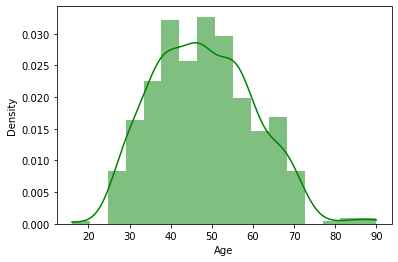

In [19]:
import seaborn as sns
import pandas as pd

data = pd.read_csv('diabetes_data_upload.csv')
sns.histplot(data.Age, color="green", kde=True, stat="density", linewidth=0)

The technique of transforming continuous data into discrete buckets by grouping it is known as data discretization. Discretization is also recognized for making data easier to maintain. When a model is trained using discrete data, it is faster and more effective than when it is trained with continuous data. Despite the fact that continuous-valued data includes more information, large volumes of data can cause the model to slow down.

Since Age column has continuos values, it is needed to apply discreatization proces with multiway split. We defined 5 intervals which are Low, Below Average, Average, Above Average, High. After that, we changed continuous Age column values with discrete values. Discretization process made our process easier to trace and understand with continuous data divided and stored into meaningful categories or groups. Moreover, due to unlimited degrees of freedom, continuous features have a lower likelihood of correlating with the goal variable and may have a complex non-linear relationship. As a result, interpreting such a function may be more difficult. Groups corresponding to the target can be interpreted after discretizing a variable. Thus, discretization is a cruicial step in this algorithm.


To create a tree, we need to have a root node first and we know that nodes are features. For each branch, we must determine the attribute that best classifies the training data and equate this attribute to the root of the tree. In ID3, the information gain method is used to determine the root node.

In [2]:
def find_total_entropy(dataframe):
    # take target values = Class[Positive, Negative]
    Class = dataframe.keys()[-1]
    target_values = dataframe[Class].unique()
    total_entropy = 0

    # for each target value like Positive, Negative calculate entropy, add to total
    for value in target_values:
        proportion = dataframe[Class].value_counts()[value] / len(dataframe[Class])
        total_entropy += -proportion * np.log2(proportion)

    return total_entropy

This function calculates the total entropy for target attributes Positive and Negative in target attribute Class.

In [3]:
def find_entropy_attribute(dataframe, column):
    # target value
    Class = dataframe.keys()[-1]
    # get target (Class) values -> Positive, Negative
    target_variables = dataframe[Class].unique()
    # get values for current column
    column_variables = dataframe[column].unique()

    column_total_entropy = 0
    for variable in column_variables:
        entropy = 0
        for target_variable in target_variables:
            # find number of columns where target variable = variable and current column variable = variable
            # ex. Class = Positive and Age = Above Average for the current training set
            numerator = len(dataframe[column][dataframe[column] == variable][dataframe[Class] == target_variable])
            # find number of columns where target variable = variable
            denominator = len(dataframe[column][dataframe[column] == variable])
            # find the proportion
            proportion = numerator / (denominator + eps)
            # get entropy for current values
            entropy += -proportion * log(proportion + eps)
        fraction2 = denominator / len(dataframe)
        # add to total entropy
        column_total_entropy += -fraction2 * entropy
    return abs(column_total_entropy)

In [4]:
def find_max_info_gain(df):
    information_gains = []
    for key in df.keys()[:-1]:  # do not include target variable
        # Gain(S,A) = Entropy(S) - sum(|S column|/|S|) Entropy(S column)
        information_gains.append(find_total_entropy(df) - find_entropy_attribute(df, key))
    # return max info gain = most effective attribute in classifying training data
    return df.keys()[:-1][np.argmax(information_gains)], max(information_gains)

The order of qualities in the nodes of a decision tree can be determined via information gain. We can use information gain to see how well the node splitting in a decision tree is. As we build the tree, we calculate information gains and select the attribute with the greatest information gaim as the next node. In order to define information gain precisely, we begin by defining a measure commonly used in information theory, called entropy that characterizes the collection of examples. Entropy is a measure of disorder or uncertainty and the goal of machine learning models in general is to reduce uncertainty.

In [5]:
# this function gets sub dataframe including columns where node = given value
def get_sub_dataframe(df, node, value):
    return df[df[node] == value].reset_index(drop=True)

In [6]:
def build_tree(df, tree=None):
    global count
    # take target value = Class[Positive, Negative]
    Class = df.keys()[-1]
    # in order to decide next node, find attribute with max information gain
    node, info_gain = find_max_info_gain(df)
    # get distinct values for that attribute like Positive, Negative
    distinct_values = df[node].unique()

    # create empty dictionary for tree representation
    if tree is None:
        count += 1
        tree = {}
        tree[node] = {}
        tree[node][count] = info_gain

    for value in distinct_values:
        sub_data_frame = get_sub_dataframe(df, node, value)
        if sub_data_frame.empty:
            continue
        clValue, counts = np.unique(sub_data_frame[Class], return_counts=True)
        if len(counts) == 1:  # check for purity
            tree[node][value] = clValue[0]
            df = data_train_2[data_train_2[node] == value].reset_index(drop=True)
        else:
            tree[node][value] = build_tree(sub_data_frame)
    return tree

In the above methods; firstly, we computed the entropy for data-set. Then, we calculated the entropy, the average information entropy, and the information gain for for every attribute/feature. We chose the attribute with the highest information gain as the root node. We repeated the same thing creating subtrees for each different value the root node had until we got the tree. We kept the tree as the form of nested dictionaries. Each node has its children, information gain and a unique node number inside its dictionary.

In [7]:
def visualize(root, indent=0):
    if type(root) == dict:
        for k, v in root.items():
            if not isinstance(k, str):
                continue
            print(" " * indent + f"{k}:")
            visualize(v, indent + 2)
    else:
        print(" " * indent + repr(root))

Visualize method allows us to easily see the tree hierarchy we created.

In [8]:
def predict(data, tree, test_sample):
    if not isinstance(tree, dict):  # if it is leaf node
        return tree  # return the value
    else:
        root_node = next(iter(tree))  # getting first key/feature name of the dictionary
        feature_value = test_sample[root_node]  # value of the feature
        sub_data_frame = get_sub_dataframe(data, root_node, feature_value)
        if feature_value in tree[root_node]:  # checking the feature value in current tree node
            return predict(sub_data_frame, tree[root_node][feature_value], test_sample)  # goto next feature
        else:
            clValue, counts = np.unique(sub_data_frame["Class"], return_counts=True)
            result = np.where(counts == np.amax(counts))
            return clValue[result[0]][0]

In the predict method, it is estimated whether the patient has diabetes (negative or positive) using the tree we created with the build_tree method. This method, starting from the root node, looks at the value of the feature that it evaluates and goes to the child node depending on this value. This process is repeated until we reach a leaf node. When this happens, the predicted category would be the mode of the categories on that leaf node. 

In [9]:
def evaluate(data, tree, test_data, label):
    predicted = []
    for index, row in test_data.iterrows():  # for each row in the dataset
        predicted.append(predict(data, tree, test_data.iloc[index]))

    le = LabelEncoder()
    predicted = le.fit_transform(predicted)
    test_data[label] = le.fit_transform(test_data[label])

    tn, fp, fn, tp = confusion_matrix(test_data[label], predicted, labels=[0, 1]).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)  # calculating accuracy
    precision = (tp) / (tp + fp)  # calculating precision
    recall = (tp) / (tp + fn)  # calculating recall
    f1 = 2 * (recall * precision) / (recall + precision)  # calculating f1 score
    print("accuracy: " + str(accuracy))
    print("precision: " + str(precision))
    print("recall: " + str(recall))
    print("f1 " + str(f1))

In [10]:
def accuracy_calculate(data, tree, test_data, label):
    predicted = []
    for index, row in test_data.iterrows():  # for each row in the dataset
        predicted.append(predict(data, tree, test_data.iloc[index]))

    le = LabelEncoder()
    predicted = le.fit_transform(predicted)
    test_data[label] = le.fit_transform(test_data[label])

    tn, fp, fn, tp = confusion_matrix(test_data[label], predicted, labels=[0, 1]).ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)  # calculating accuracy
    return accuracy

This method evaluations performance metrics of a classification-based our machine learning model. It displays our decision tree model’s precision, recall, F1 score and accuracy. It provides a better understanding of the overall performance of our trained model.

In [11]:
def k_fold_cross_validation(data):
    global data_train_2
    global count
    i = 1
    # define sklearn KFold
    kf = KFold(n_splits=5, shuffle=True)
    # split data frame to 5
    kf.split(data)
    trees = []
    # loop over 5 different test & training data, call function
    print("-------------------- PART 1 --------------------")
    for train_index, test_index in kf.split(data):
        start = time.time()
        data_train, data_test = data.iloc[train_index].reset_index(drop=True), \
                                data.iloc[test_index].reset_index(drop=True)
        print()
        print("------------------------------------------------")
        print("Fold-"+str(i))
        i += 1
        count = 0
        data_train_2 = data_train
        tree = build_tree(data_train)
        trees.append(tree)
        evaluate(data, tree, data_test, "Class")
        end = time.time()
        print(f"Runtime of the program is {end - start}")
    return trees

K-fold cross validation is where a given data set is split into a K number of folds where each fold is used as a testing set at some point. In our assignment, we take the scenario of 5-Fold cross validation(K=5). Here, the data set is splitted into 5 folds. In each iteration, a fold is used to test the model and the rest are used to train the model (to build the tree).

In [26]:
count = 0
data_train_2 = pandas.DataFrame
trees = part1()

-------------------- PART 1 --------------------

------------------------------------------------
Fold-1
accuracy: 0.9519230769230769
precision: 0.9464285714285714
recall: 0.9636363636363636
f1 0.9549549549549549
Runtime of the program is 0.9244682788848877

------------------------------------------------
Fold-2
accuracy: 0.9326923076923077
precision: 0.9428571428571428
recall: 0.9565217391304348
f1 0.9496402877697843
Runtime of the program is 0.9575800895690918

------------------------------------------------
Fold-3
accuracy: 0.9519230769230769
precision: 0.9384615384615385
recall: 0.9838709677419355
f1 0.9606299212598426
Runtime of the program is 0.8984682559967041

------------------------------------------------
Fold-4
accuracy: 0.9711538461538461
precision: 0.9558823529411765
recall: 1.0
f1 0.9774436090225563
Runtime of the program is 0.9363248348236084

------------------------------------------------
Fold-5
accuracy: 0.9230769230769231
precision: 0.9178082191780822
recall: 0.

For the results illustrated above, the best accuracy, precision, recall and f1 scores exits in Fold-4. Tree created for Fold-4 can be seen below.

In [27]:
# best accuracy
visualize(trees[3])

Polyuria:
  No:
    Gender:
      Male:
        Irritability:
          No:
            Polydipsia:
              Yes:
                Itching:
                  Yes:
                    Alopecia:
                      Yes:
                        Obesity:
                          Yes:
                            'Positive'
                      No:
                        'Negative'
                  No:
                    'Positive'
              No:
                Age:
                  Average:
                    partial paresis:
                      Yes:
                        muscle stiffness:
                          No:
                            'Positive'
                      No:
                        'Negative'
                  Below_average:
                    delayed healing:
                      Yes:
                        Genital thrush:
                          Yes:
                            Polyphagia:
                              Yes:
              

Rules of the best performing decision tree model (Fold-4 decision tree):

(Polyuria=No) and (Gender=Male) and (Irritability=No) and (Polydipsia=Yes) and (Itching=Yes) and (Alopecia=Yes) and (Obesity=Yes) = Positive or

(Polyuria=No) and (Gender=Male) and (Irritability=No) and (Polydipsia=Yes) and (Itching=Yes) and (Alopecia=No) = Negative or 

(Polyuria=No) and (Gender=Male) and (Irritability=No) and (Polydipsia=Yes) and (Itching=No) = Positive or 

(Polyuria=No) and (Gender=Male) and (Irritability=No) and (Polydipsia=No) and (Age=Average) and (partial paresis=Yes) and (muscle stiffness=No) = Positive or

(Polyuria=No) and (Gender=Male) and (Irritability=No) and (Polydipsia=No) and (Age=Average) and (partial paresis=No) = Negative or 

(Polyuria=No) and (Gender=Male) and (Irritability=No) and (Polydipsia=No) and (Age=Below Average) and (delayed healing=Yes) and (Genital thrush=Yes) and (Polyphagia=Yes) = Positive or

(Polyuria=No) and (Gender=Male) and (Irritability=No) and (Polydipsia=No) and (Age=Below Average) and (delayed healing=Yes) and (Genital thrush=No) = Positive or 

(Polyuria=No) and (Gender=Male) and (Irritability=No) and (Polydipsia=No) and (Age=Below Average) and (delayed healing=No) = Negative or 

(Polyuria=No) and (Gender=Male) and (Irritability=No) and (Polydipsia=No) and (Age=Above Average) and (partial paresis=Yes) = Positive or 

(Polyuria=No) and (Gender=Male) and (Irritability=Yes) and (Polydipsia=Yes) = Positive or 

(Polyuria=No) and (Gender=Female) and (Alopecia=No) and (visual blurring=Yes) = Positive or 

(Polyuria=No) and (Gender=Female) and (Alopecia=Yes) and (Age=Low) = Positive or 

(Polyuria=Yes) and (Polydipsia=No) and (Itching=Yes) and (delayed healing=Yes) and (Alopecia=Yes) and (Gender=Male) and (Age=Below Average) and (sudden weight loss=No) = Positive or 

(Polyuria=Yes) and (Polydipsia=No) and (Itching=Yes) and (delayed healing=Yes) and (Alopecia=Yes) and (Gender=Male) and (Age=Above Average) = Negative or 

(Polyuria=Yes) and (Polydipsia=No) and (Itching=Yes) and (delayed healing=Yes) and (Alopecia=Yes) and (Gender=Female) = Positive or 

(Polyuria=Yes) and (Polydipsia=No) and (Itching=Yes) and (delayed healing=Yes) and (Alopecia=No) = Positive or

(Polyuria=Yes) and (Polydipsia=No) and (Itching=Yes) and (delayed healing=No) = Positive or

(Polyuria=Yes) and (Polydipsia=No) and (Itching=No) = Positive or 

(Polyuria=Yes) and (Polydipsia=Yes) = Positive or 

## Analysis of the Results for Decision Tree Classification

Decision Tree is a Supervised learning technique that can be used for both classification and Regression problems, but mostly it is preferred for solving Classification problems.
A decision tree is a tree where each node represents a feature, each branch represents a rule and each leaf represents an outcome. Each node is either used to make a decision or represent an outcome (leaf node).

ID3 stands for Iterative Dichotomiser 3 and is named such because the algorithm iteratively (repeatedly) divides features into two or more groups at each step.
ID3 uses a top-down greedy approach to build a decision tree. So, the top-down approach means that we start building the tree from the top and the greedy approach means that at each iteration we select the best feature at the present moment to create a node. Information gain is used for the best feature selection. Information gain calculates the reduction in the entropy and measures how well a given feature separates or classifies the target classes. The feature with the highest information gain is best feature.

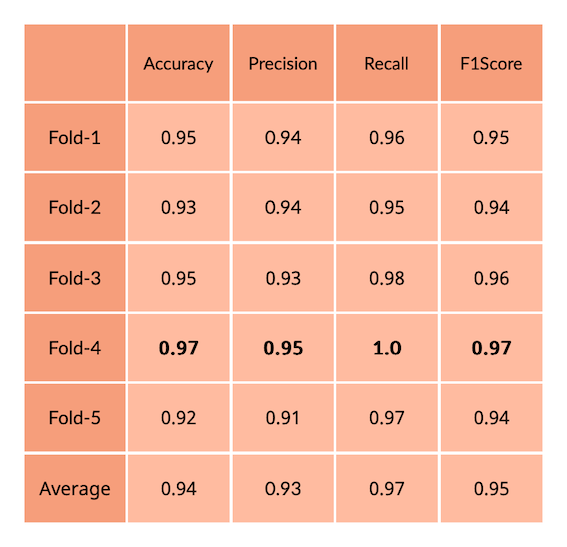

Accuracy, precision, recall and fscore values are observed for each model we create. This table is one of the performance evaluation metrics of a classification-based machine learning model. It displays our model’s precision, recall, F1 score and accuracy. It provides a better understanding of the overall performance of our trained model. 


Accuracy is an evaluation metric that allows you to measure the total number of predictions a model gets right. It is the ratio of the total number of correct predictions and the total number of predictions. In simple words, it tells us how many predictions are actually positive out of all the total positive predicted.
As we can see in the table, the accuracy of the 5 models created varies between 0.92 - 0.97 and the average accuracy of our models is 0,94. We see that the highest accuracy value is 0.97 and this model is established with fold-3 data. That is, our model correctly predicts 97 out of a total of 100 samples. This means our decision tree classifier does a great job in determining that a patient is potentially diabetic.

Precision evaluates how precise a model is in predicting positive labels. In the simplest terms, it is the ratio between the true positives and all the positives. For our problem statement, that would be the measure of patients that we correctly identify having a diabetes out of all the patients actually having it. The precision of a measurement system is refers to how close the agreement is between repeated measurements (which are repeated under the same conditions). High precision relates to the low false positive rate. The precision value of the 5 models we created varies between 0.91 - 0.95 and the average precision of our models is 0.93. In our model built with fold-3 data, we have an precision of 0.95, which is good.

The recall is the measure of our model correctly identifying True Positives. It is the ratio of correctly predicted positive observations to the all observations in actual class.Recall is a valid choice of evaluation metric when we want to capture as many positives as possible. Thus, for all the patients who actually have diabetes, recall tells us how many we correctly identified as having a diabetes. We see in the table, the recall of the 5 models created varies between 0.95 - 1.0 and the average recall value of our models is 0,97. We see that the highest recall value is 1.0 and this model is established with fold-3 data. This result shows that we correctly labeled 100% of patients with diabetes.

The F1 score is the weighted harmonic mean of precision and recall. Therefore, this score takes both false positives and false negatives into account. F1 score is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both precision and recall. The closer the value of the F1 score is to 1.0, the better the expected performance of the model is. As we can see in the table, the F1 score of the 5 models created varies between 0.94 - 0.97 and the average F1 score of our models is 0,95. In our model built with fold-3 data, we have the highest F1 score of 0.97, which is pretty good.


The decision tree approach aims to determine a profile / pattern of the values that the target class will take by monitoring the values of the predictive classes in the data set. In the table above, we see that the model with the highest accuracy, precision, recall and f1 score values was established with the fold-3 dataset. It is not surprising that these 4 values, which allow us to analyze the performance of the model, give the highest result in the same model. Since the decision tree was fully grown in the algorithm, our model lost its generalizability. When we examine the model created with Fold-3, we see that overfitting has occurred.
Overfitting can be summarized as the situation where the algorithm loses its flexibility to adapt to other data sets by memorizing the data set completely. As a result, our decision tree became unnecessarily complex. As in this example, we need to prune decision trees to solve overfit situations.

## Part 2: Pruning Decision Tree

As the number of splits in decision trees increase, their complexity rises. In general, simpler decision trees are preferred over super complex ones, since they are easier to understand and they are less likely to fall into overfitting. Overfitting refers to a model that learns the training data (the data it uses to learn) so well that it has problems to generalize to unseen data. It’s always better to avoid a decision tree model that learns and repeats specific details, and try to develop one that has the power and flexibility to have a decent performance on new data we provide to it.
Pruning is a technique used to deal with overfitting, that reduces the size of decision trees by removing sections of the tree that provide little predictive or classification power.

In [12]:
def train_validation_test_splitter(dataframe):
    train, test = train_test_split(dataframe, test_size=0.2, shuffle=True)
    train, validation = train_test_split(train, test_size=0.25)

    return train, test, validation

The train_validation_test_splitter method splits the dataset into train, test and validation.  Train dataset is the actual dataset that we use to train the model. The model sees and learns from this data. Validation dataset is the sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. Test Dataset is the sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

In [13]:
# checks if a node is a leaf
def is_leaf(node):
    if isinstance(node, dict):
        return False
    
    return True

In [14]:
# checks if a node is a twig
def is_twig(node):
    for child in node.keys():
        if is_leaf(node[child]) is False:
            return False
    return True

In [15]:
# finds all twigs in the tree
def find_twigs(tree, twigs):
    root_node = next(iter(tree))

    if is_twig(tree[root_node]):
        twigs.append(tree[root_node])  # add info gain
    else:
        for value in tree[root_node].keys():  # checking the feature value in current tree node
            if is_leaf(tree[root_node][value]):
                continue
            find_twigs(tree[root_node][value], twigs)  # goto next feature

    return twigs

This function is used in the pruning process' first step where we find all twigs in our decision tree

In [16]:
# finds the twig with the least information gain
def find_least_info_gain_twig(twigs):
    min_info_gain = 1
    node_num = 0

    for twig in twigs:
        counter = 0
        for key, value in twig.items():
            if counter == 0:
                if value < min_info_gain:
                    min_info_gain = value
                    node_num = key
            counter += 1

    return node_num

After we find twigs, we need to determine which twig should be relabed. According to the given rule, it is required to find the twig which has the least information gain. We compare information gain values of twigs inside this function and return the related twig.

In [17]:
# deletes the children of the branch with the least information gain
def delete_children(tree, node_num):
    root_node = next(iter(tree))

    for value in tree[root_node].keys():
        if is_leaf(tree[root_node][value]):
            continue
        if node_num == get_node_num(tree[root_node][value]):
            tree[root_node][value] = get_node_value(tree[root_node][value])
            return tree
        else:
            delete_children(tree[root_node][value], node_num)

    return tree

After we find twig with the least information gain. We need to remove all childs of that twig. The function above handles this part of the algorithm.

In [18]:
def get_node_num(node):
    root_node = next(iter(node))

    counter = 0
    for key, value in node[root_node].items():
        if counter == 0:
            return key

In our tree implementation, each node has a unique node number which allows us to distinguish between them when we want to compare information gains or when we traverse the tree and try to find a specific node.

In [19]:
def get_node_value(node):
    root_node = next(iter(node))

    counter = 0
    for key, value in node[root_node].items():
        if counter == 1:
            return value
        counter += 1

In [21]:
def prune(data):
    global data_train_2
    print("-------------------- PART 2 --------------------")
    train, test, validation = train_validation_test_splitter(data)
    data_train_2 = train
    tree = build_tree(train)
    last_accuracy = accuracy_calculate(data, tree, test.reset_index(drop=True), "Class")
    print()
    print("Last accuracy: " +str(last_accuracy))
    pruned_tree, new_accuracy = repeat_prune(data, tree, validation, last_accuracy)
    print("New accuracy: "+ str(new_accuracy))
    print("-------------------------------------------------------")
    

In [22]:
def repeat_prune(data, tree, validation, last_accuracy):
    twigs = find_twigs(tree, [])
    node_num = find_least_info_gain_twig(twigs)
    updated_tree = delete_children(tree, node_num)
    current_accuracy = accuracy_calculate(data, updated_tree, validation.reset_index(drop=True), "Class")
    print("Current accuracy: "+ str(current_accuracy))
    if current_accuracy <= last_accuracy:
        return tree, last_accuracy
    else:
        return repeat_prune(data, updated_tree, validation, current_accuracy)

The Prune method reduces the size of the Decision Tree by removing sections of the tree that are non-critical and redundant to classify instances. This way, we reduce the complexity of tree, and thus increasing its predictive power by reducing overfitting.

In this assignment, pruning starts at the leaves. The twigs are the nodes whose children are all leaves. The leaf nodes of the twig with the smallest information gain are removed from all twigs in the tree. This change is retained as long as it does not reduce accuracy. The recursive algorithm invokes itself with the new accuracy value only if the current accuracy is greater than the last accuracy, which means that pruning the current node makes a positince impact by increasing the accuracy.

In [20]:
def part2():
    data = pd.read_csv('diabetes_data_upload.csv')
    # discretization for continuous variable Age, split Age values to 5 different ranges -> make it discrete
    data['age_discrete'] = pd.cut(data['Age'], 5, labels=['Low', 'Below_average', 'Average', 'Above_Average', 'High'])
    # write discretized age values to Age column
    data['Age'] = data['age_discrete']
    # drop unnecessary column
    data = data.drop(columns="age_discrete")
    prune(data)

In [36]:
part2()

-------------------- PART 2 --------------------

Last accuracy: 0.9230769230769231
Current accuracy: 0.9519230769230769
Current accuracy: 0.9519230769230769
New accuracy: 0.9519230769230769
-------------------------------------------------------


Any training data used to train decision trees runs the risk of overfitting the data. This means that each leaf will eventually represent a highly specific set of attribute combinations seen in the training data, and the tree will be unable to classify attribute value combinations that are not seen in the training data. We must prune the decision tree to avoid this from happening. Pruning should reduce the size of a learning tree without reducing predictive accuracy. Pruning a decision tree means to remove a subtree that is redundant and not a useful split and replace it with a leaf node. It reduces the complexity of the final classifier, and hence improves predictive accuracy by the reduction of overfitting. In the pruning process, it can be seen from the result above that, the accuracy value rises up from 93.2 to 95.19 when we apply the pruning algorithm appropriately.